## 00. Imports

In [8]:
import cv2
import numpy as np
import rawpy
import matplotlib.pyplot as plt

## 01. RANSAC on RAW photos

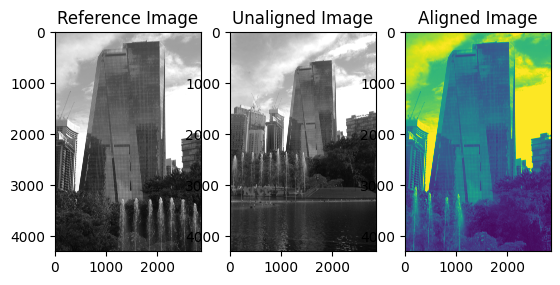

In [ ]:
def read_image(filename):
    """Reads an image and converts it to grayscale."""
    if filename.lower().endswith(('.nef', '.cr2', '.arw', '.dng', '.rw2')):  # RAW formats
        with rawpy.imread(filename) as raw:
            rgb = raw.postprocess()
        image = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    else:  # Assume JPG or PNG
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError(f"Failed to read image: {filename}")
    
    return image

def align_images(img1, img2):
    """Aligns img2 to img1 using ORB feature matching and RANSAC."""
    orb = cv2.ORB_create(5000)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1
        aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        
        return aligned_img, H
    else:
        raise ValueError("Not enough matches found.")

# Example usage
DIR = "first-dataset-RAW/"
image1_path = f"{DIR}IMG_7781.CR2"
image2_path = f"{DIR}IMG_7782.CR2"

img1 = read_image(image1_path)
img2 = read_image(image2_path)

aligned_img, homography = align_images(img1, img2)

# Show results
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title("Reference Image")

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title("Unaligned Image")

plt.subplot(1, 3, 3)
plt.imshow(aligned_img, cmap='gray')
plt.title("Aligned Image")

plt.show()


## 02. RANSAC on JPG photos

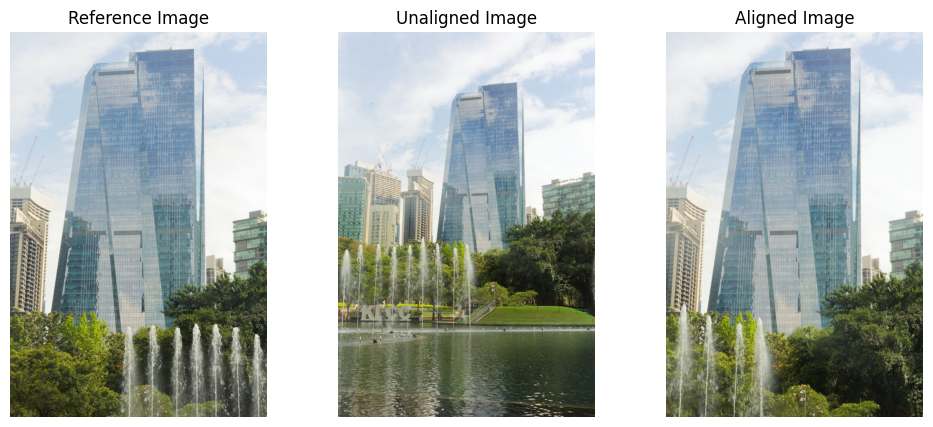

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_image(filename):
    """Reads a JPG/PNG image in color (BGR format)."""
    image = cv2.imread(filename)
    if image is None:
        raise ValueError(f"Failed to read image: {filename}")
    return image

def align_images(img1, img2):
    """Aligns img2 to img1 using ORB feature matching and RANSAC."""
    orb = cv2.ORB_create(5000)

    # Convert images to grayscale for feature detection
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort by distance

    # Use RANSAC to find homography
    if len(matches) > 10:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Warp img2 to align with img1 (preserving colors)
        aligned_img = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
        
        return aligned_img, H
    else:
        raise ValueError("Not enough matches found.")

# Example usage
DIR = "first-dataset-JPG/"
image1_path = f"{DIR}IMG_7781_DxO.JPG"
image2_path = f"{DIR}IMG_7782_DxO.JPG"  

img1 = read_image(image1_path)
img2 = read_image(image2_path)

aligned_img, homography = align_images(img1, img2)

# Convert BGR to RGB for correct color display in Matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
aligned_img_rgb = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)

# Show results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.title("Reference Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2_rgb)
plt.title("Unaligned Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(aligned_img_rgb)
plt.title("Aligned Image")
plt.axis('off')

plt.show()
